In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import regex as re

In [2]:
# https://www.kaggle.com/datasets/laurindogarcia/covid-19-race-gender-poverty-risk-us-county


# Data is drawn from:

# USA Facts/U.S CDC,
# SAIPE/U.S Census,
# Population Estimates/U.S Census,
# Policy Map/NY Times/2017 SMART-BRFSS, U.S CDC
# Links to sources are in the file description below.


# About this file
# This files is a consolidation of data from the following sources:

# US Coronavirus Cases (USA Facts/U.S CDC, 2020): timeseries from 22/01/2020 to 31/07/2020;
# https://usafacts.org/visualizations/coronavirus-covid-19-spread-map/

# US Coronavirus Deaths (USA Facts/U.S. CDC, 2020): timeseries from 22/01/2020 to 31/07/2020;
# https://usafacts.org/visualizations/coronavirus-covid-19-spread-map/

# State/County Poverty Universe Data, All ages (SAIPE, U.S Census, 2019);
# https://www.census.gov/data/datasets/time-series/demo/saipe/model-tables.html

# Annual County Resident Population Estimates by Age, Sex, Race, and Hispanic Origin: April 1, 2010 to July 1, 2019 (CC-EST2019-ALLDATA) (U.S Census, 2019);
# https://www.census.gov/data/tables/time-series/demo/popest/2010s-counties-detail.html

# Severe COVID-19 Health Risk Index by U.S County (Policy Map/NY Times/2017 SMART-BRFSS, U.S CDC, 2017
## No available website for that one (yikes)

In [3]:
cd_log = pd.read_csv("covid_data_log_200908.csv")
cd_log

,FIPS,stateFIPS,countyFIPS_2d,County,State,Cases,Deaths,Poverty,Population,W_Male,...,B_Male,B_Female,I_Male,I_Female,A_Male,A_Female,NH_Male,NH_Female,Risk_Index,Risk_Cat
0,1001,1,1,Autauga County,AL,10.590264,6.812345,10.916415,10.930765,10.651360,...,9.282754,9.414913,5.978886,6.100319,6.588926,6.778785,4.465908,4.317488,65.42,Above Average
1,1003,1,3,Baldwin County,AL,11.251171,6.864848,12.279579,12.315976,12.162852,...,9.895052,9.957739,7.908755,7.872455,7.756623,8.129764,5.537334,5.587249,68.39,Above Average
2,1005,1,5,Barbour County,AL,10.111517,5.043425,9.997843,10.113992,9.465448,...,9.452737,9.330787,5.652489,5.204007,4.844187,4.948760,4.276666,3.713572,97.09,High
3,1007,1,7,Bibb County,AL,9.520469,4.634729,9.914032,10.016548,9.777641,...,8.691315,8.221210,5.068904,5.017280,4.276666,4.290459,3.912023,2.772589,83.36,Above Average
4,1009,1,9,Blount County,AL,9.868430,4.406719,10.954973,10.965194,10.912649,...,7.068172,6.984716,6.383507,6.393591,5.446737,5.579730,4.624973,4.127134,81.75,Above Average
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,56037,56,37,Sweetwater County,WY,8.903951,3.526361,10.650294,10.653558,10.629223,...,6.719013,6.461468,6.781058,6.685861,6.246107,6.428105,4.574711,4.595120,10.42,Low
3138,56039,56,39,Teton County,WY,9.534089,4.615121,10.038368,10.063223,10.057410,...,5.513429,5.198497,5.736572,5.605802,5.880533,6.350886,4.143135,3.761200,2.94,Very low
3139,56041,56,41,Uinta County,WY,9.183688,0.000000,9.910215,9.914724,9.888272,...,5.293305,5.225747,5.968708,5.996452,4.812184,5.192957,3.988984,3.784190,27.13,Below Average
3140,56043,56,43,Washakie County,WY,8.040447,5.673323,8.953511,8.962520,8.936167,...,4.382027,4.043051,5.129899,5.288267,4.189655,4.624973,2.564949,2.564949,32.76,Below Average


In [4]:
# Risk_Index is a float score, not sure based on what, but not one we want to manipulate.
# These have all been log transformed, moving over into integers may be helpful with aggregating with CRE data

cd_log.dtypes

FIPS               int64
stateFIPS          int64
countyFIPS_2d      int64
County            object
State             object
Cases            float64
Deaths           float64
Poverty          float64
Population       float64
W_Male           float64
W_Female         float64
B_Male           float64
B_Female         float64
I_Male           float64
I_Female         float64
A_Male           float64
A_Female         float64
NH_Male          float64
NH_Female        float64
Risk_Index       float64
Risk_Cat          object
dtype: object

In [5]:
ignore = ['FIPS', 'stateFIPS', 'countyFIPS_2d', 'Risk_Cat', 'County', 'State','Risk_Index']

# def exp_transform(cd_log):
cd_log2 = cd_log.copy()

for (columnName, columnData) in cd_log2.iteritems():
    if columnName not in ignore:
#         print(columnName)
        column_list = cd_log2[columnName].values.tolist()
#         print(column_list)
        weep = [np.exp(pip) for pip in column_list]
#         print(weep)
        cd_log2.drop([columnName], axis = 1)
        cd_log2[columnName] = weep
        
        

        

  

In [6]:
# Risk index made more sense staying w log transformation but I can revert it back if we decide we want to by removing it from 
## the ignore list above.

cd_log2

,FIPS,stateFIPS,countyFIPS_2d,County,State,Cases,Deaths,Poverty,Population,W_Male,...,B_Male,B_Female,I_Male,I_Female,A_Male,A_Female,NH_Male,NH_Female,Risk_Index,Risk_Cat
0,1001,1,1,Autauga County,AL,39746.0,909.0,55073.0,55869.0,42250.0,...,10751.0,12270.0,395.0,446.0,727.0,879.0,87.0,75.0,65.42,Above Average
1,1003,1,3,Baldwin County,AL,76970.0,958.0,215255.0,223234.0,191540.0,...,19832.0,21115.0,2721.0,2624.0,2337.0,3394.0,254.0,267.0,68.39,Above Average
2,1005,1,5,Barbour County,AL,24625.0,155.0,21979.0,24686.0,12906.0,...,12743.0,11280.0,285.0,182.0,127.0,141.0,72.0,41.0,97.09,High
3,1007,1,7,Bibb County,AL,13636.0,103.0,20212.0,22394.0,17635.0,...,5951.0,3719.0,159.0,151.0,72.0,73.0,50.0,16.0,83.36,Above Average
4,1009,1,9,Blount County,AL,19311.0,82.0,57238.0,57826.0,54866.0,...,1174.0,1080.0,592.0,598.0,232.0,265.0,102.0,62.0,81.75,Above Average
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,56037,56,37,Sweetwater County,WY,7361.0,34.0,42205.0,42343.0,41325.0,...,828.0,640.0,881.0,801.0,516.0,619.0,97.0,99.0,10.42,Low
3138,56039,56,39,Teton County,WY,13823.0,101.0,22888.0,23464.0,23328.0,...,248.0,181.0,310.0,272.0,358.0,573.0,63.0,43.0,2.94,Very low
3139,56041,56,41,Uinta County,WY,9737.0,1.0,20135.0,20226.0,19698.0,...,199.0,186.0,391.0,402.0,123.0,180.0,54.0,44.0,27.13,Below Average
3140,56043,56,43,Washakie County,WY,3104.0,291.0,7735.0,7805.0,7602.0,...,80.0,57.0,169.0,198.0,66.0,102.0,13.0,13.0,32.76,Below Average


In [7]:
##DIFFERENT DATASET

cd_log3 = pd.read_csv("covid_data_log_200922.csv")
cd_log3


,FIPS,stateFIPS,countyFIPS_2d,County,State,Cases,Deaths,Poverty,Population,W_Male,...,H_Male,H_Female,I_Male,I_Female,A_Male,A_Female,NH_Male,NH_Female,Risk_Index,Risk_Cat
0,1001,1,1,Autauga County,AL,10.590264,6.812345,10.916415,10.930765,10.651360,...,7.903227,7.787797,5.978886,6.100319,6.588926,6.778785,4.465908,4.317488,65.42,Above Average
1,1003,1,3,Baldwin County,AL,11.251171,6.864848,12.279579,12.315976,12.162852,...,9.734477,9.629182,7.908755,7.872455,7.756623,8.129764,5.537334,5.587249,68.39,Above Average
2,1005,1,5,Barbour County,AL,10.111517,5.043425,9.997843,10.113992,9.465448,...,7.552762,7.291656,5.652489,5.204007,4.844187,4.948760,4.276666,3.713572,97.09,High
3,1007,1,7,Bibb County,AL,9.520469,4.634729,9.914032,10.016548,9.777641,...,6.944087,6.746412,5.068904,5.017280,4.276666,4.290459,3.912023,2.772589,83.36,Above Average
4,1009,1,9,Blount County,AL,9.868430,4.406719,10.954973,10.965194,10.912649,...,9.092570,8.980424,6.383507,6.393591,5.446737,5.579730,4.624973,4.127134,81.75,Above Average
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,56037,56,37,Sweetwater County,WY,8.903951,3.526361,10.650294,10.653558,10.629223,...,9.284241,9.185330,6.781058,6.685861,6.246107,6.428105,4.574711,4.595120,10.42,Low
3138,56039,56,39,Teton County,WY,9.534089,4.615121,10.038368,10.063223,10.057410,...,8.648923,8.525955,5.736572,5.605802,5.880533,6.350886,4.143135,3.761200,2.94,Very low
3139,56041,56,41,Uinta County,WY,9.183688,0.000000,9.910215,9.914724,9.888272,...,7.938802,7.964156,5.968708,5.996452,4.812184,5.192957,3.988984,3.784190,27.13,Below Average
3140,56043,56,43,Washakie County,WY,8.040447,5.673323,8.953511,8.962520,8.936167,...,7.446585,7.410347,5.129899,5.288267,4.189655,4.624973,2.564949,2.564949,32.76,Below Average


In [8]:
ignore = ['FIPS', 'stateFIPS', 'countyFIPS_2d', 'Risk_Cat', 'County', 'State','Risk_Index']

# def exp_transform(cd_log):
cd_log4 = cd_log3.copy()

for (columnName, columnData) in cd_log4.iteritems():
    if columnName not in ignore:
#         print(columnName)
        column_list2 = cd_log4[columnName].values.tolist()
#         print(column_list)
        meepmeep = [np.exp(meep) for meep in column_list2]
        cd_log4.drop([columnName], axis = 1)
        cd_log4[columnName] = meepmeep
        

        
        
        

In [9]:
# Dope

cd_log4

,FIPS,stateFIPS,countyFIPS_2d,County,State,Cases,Deaths,Poverty,Population,W_Male,...,H_Male,H_Female,I_Male,I_Female,A_Male,A_Female,NH_Male,NH_Female,Risk_Index,Risk_Cat
0,1001,1,1,Autauga County,AL,39746.0,909.0,55073.0,55869.0,42250.0,...,2706.0,2411.0,395.0,446.0,727.0,879.0,87.0,75.0,65.42,Above Average
1,1003,1,3,Baldwin County,AL,76970.0,958.0,215255.0,223234.0,191540.0,...,16890.0,15202.0,2721.0,2624.0,2337.0,3394.0,254.0,267.0,68.39,Above Average
2,1005,1,5,Barbour County,AL,24625.0,155.0,21979.0,24686.0,12906.0,...,1906.0,1468.0,285.0,182.0,127.0,141.0,72.0,41.0,97.09,High
3,1007,1,7,Bibb County,AL,13636.0,103.0,20212.0,22394.0,17635.0,...,1037.0,851.0,159.0,151.0,72.0,73.0,50.0,16.0,83.36,Above Average
4,1009,1,9,Blount County,AL,19311.0,82.0,57238.0,57826.0,54866.0,...,8889.0,7946.0,592.0,598.0,232.0,265.0,102.0,62.0,81.75,Above Average
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,56037,56,37,Sweetwater County,WY,7361.0,34.0,42205.0,42343.0,41325.0,...,10767.0,9753.0,881.0,801.0,516.0,619.0,97.0,99.0,10.42,Low
3138,56039,56,39,Teton County,WY,13823.0,101.0,22888.0,23464.0,23328.0,...,5704.0,5044.0,310.0,272.0,358.0,573.0,63.0,43.0,2.94,Very low
3139,56041,56,41,Uinta County,WY,9737.0,1.0,20135.0,20226.0,19698.0,...,2804.0,2876.0,391.0,402.0,123.0,180.0,54.0,44.0,27.13,Below Average
3140,56043,56,43,Washakie County,WY,3104.0,291.0,7735.0,7805.0,7602.0,...,1714.0,1653.0,169.0,198.0,66.0,102.0,13.0,13.0,32.76,Below Average


In [10]:
## I wonder what performing a merge would do
merged_df = cd_log2.merge(cd_log4)
merged_df

## Why do these datasets look exactly the same?
## Checked the CSV, they are exactly the same (thirty minutes later)


,FIPS,stateFIPS,countyFIPS_2d,County,State,Cases,Deaths,Poverty,Population,W_Male,...,I_Male,I_Female,A_Male,A_Female,NH_Male,NH_Female,Risk_Index,Risk_Cat,H_Male,H_Female
0,1001,1,1,Autauga County,AL,39746.0,909.0,55073.0,55869.0,42250.0,...,395.0,446.0,727.0,879.0,87.0,75.0,65.42,Above Average,2706.0,2411.0
1,1003,1,3,Baldwin County,AL,76970.0,958.0,215255.0,223234.0,191540.0,...,2721.0,2624.0,2337.0,3394.0,254.0,267.0,68.39,Above Average,16890.0,15202.0
2,1005,1,5,Barbour County,AL,24625.0,155.0,21979.0,24686.0,12906.0,...,285.0,182.0,127.0,141.0,72.0,41.0,97.09,High,1906.0,1468.0
3,1007,1,7,Bibb County,AL,13636.0,103.0,20212.0,22394.0,17635.0,...,159.0,151.0,72.0,73.0,50.0,16.0,83.36,Above Average,1037.0,851.0
4,1009,1,9,Blount County,AL,19311.0,82.0,57238.0,57826.0,54866.0,...,592.0,598.0,232.0,265.0,102.0,62.0,81.75,Above Average,8889.0,7946.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,56037,56,37,Sweetwater County,WY,7361.0,34.0,42205.0,42343.0,41325.0,...,881.0,801.0,516.0,619.0,97.0,99.0,10.42,Low,10767.0,9753.0
3138,56039,56,39,Teton County,WY,13823.0,101.0,22888.0,23464.0,23328.0,...,310.0,272.0,358.0,573.0,63.0,43.0,2.94,Very low,5704.0,5044.0
3139,56041,56,41,Uinta County,WY,9737.0,1.0,20135.0,20226.0,19698.0,...,391.0,402.0,123.0,180.0,54.0,44.0,27.13,Below Average,2804.0,2876.0
3140,56043,56,43,Washakie County,WY,3104.0,291.0,7735.0,7805.0,7602.0,...,169.0,198.0,66.0,102.0,13.0,13.0,32.76,Below Average,1714.0,1653.0


In [11]:
## Load in CRE Equity Supplemental Data for funsies
cree = pd.read_csv("CRE_Equity_County_19.csv",engine='python',encoding='latin1')
cree

,GEO_ID,NAME,POPUNI,PRED0_E,PRED0_M,PRED0_PE,PRED0_PM,PRED0_PF,PRED12_E,PRED12_M,...,Broadband_PF,No_Veh_PE,No_Veh_PM,No_Veh_PF,HO_Vac_PE,HO_Vac_PM,HO_Vac_PF,Rent_Vac_PE,Rent_Vac_PM,Rent_Vac_PF
0,0500000US01001,"Autauga County, Alabama",55688,20573,6265,36.94,11.25,0,22750,6438,...,-1,4.4,0.9,-1,1.4,0.6,0,3.1,1.7,-1
1,0500000US01003,"Baldwin County, Alabama",221898,78622,21331,35.43,9.61,0,90552,22201,...,0,3.3,0.4,-1,3.3,0.7,1,43.6,2.2,1
2,0500000US01005,"Barbour County, Alabama",22023,5024,2126,22.81,9.65,-1,9171,2424,...,-1,10.2,2.0,0,3.8,1.4,1,7.4,3.0,0
3,0500000US01007,"Bibb County, Alabama",20393,6280,2060,30.79,10.10,0,8986,2212,...,-1,6.2,2.4,0,1.5,1.3,0,5.6,5.4,0
4,0500000US01009,"Blount County, Alabama",57697,18189,4926,31.53,8.54,0,23950,5265,...,-1,4.1,1.1,-1,0.7,0.4,-1,8.4,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,0500000US56037,"Sweetwater County, Wyoming",41888,16977,4573,40.53,10.92,0,17781,4745,...,0,1.7,0.7,-1,2.1,0.9,0,30.6,5.0,1
3138,0500000US56039,"Teton County, Wyoming",23390,7250,2773,31.00,11.86,0,11567,2922,...,1,2.4,1.4,-1,2.0,1.9,0,24.5,5.7,1
3139,0500000US56041,"Uinta County, Wyoming",20183,7744,2081,38.37,10.31,0,9346,2184,...,1,3.4,1.2,-1,0.5,0.5,-1,11.9,7.4,0
3140,0500000US56043,"Washakie County, Wyoming",7738,2601,880,33.61,11.37,0,3215,951,...,0,4.9,2.3,-1,0.2,0.2,-1,24.6,10.6,1


In [12]:
cree.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3142 entries, 0 to 3141
Columns: 105 entries, GEO_ID to Rent_Vac_PF
dtypes: float64(61), int64(42), object(2)
memory usage: 2.5+ MB


In [13]:
cree.columns

Index(['GEO_ID', 'NAME', 'POPUNI', 'PRED0_E', 'PRED0_M', 'PRED0_PE',
       'PRED0_PM', 'PRED0_PF', 'PRED12_E', 'PRED12_M',
       ...
       'Broadband_PF', 'No_Veh_PE', 'No_Veh_PM', 'No_Veh_PF', 'HO_Vac_PE',
       'HO_Vac_PM', 'HO_Vac_PF', 'Rent_Vac_PE', 'Rent_Vac_PM', 'Rent_Vac_PF'],
      dtype='object', length=105)

In [14]:
# Flags & Statistical Uncertainty
# As with most products the Census Bureau creates many of the estimates in the data set have
# some statistical uncertainty because of survey sampling techniques. To address this, a measure
# of uncertainty is attached to these estimates know as a margin of error.
# In addition to providing a margin of error, the CRE for Equity Dataset has “flag” variables. These
# variables are provided to denote whether a statistical difference exists between the estimate
# for a geographic area and the estimate for the United States. These statistical tests are
# performed using the estimates and their accompanying margins of error.
# These flags should allow data users to quickly determine differences of note when analyzing
# certain geographic areas. Additional information about these flags, instances where statistical
# testing is not performed, and the meaning of the values can be found in the “CRE for Equity File
# Layout” document. More information about performing statistical testing with American
# Commuinity Survey data can be found at < https://www2.census.gov/programssurveys/acs/tech_docs/statistical_testing/2019_Instructions_for_Stat_Testing_ACS.pdf>.
# Contact Information
# R. Chase Sawyer, Team Lead for the CRE in the Social, Economic, and Housing Statistics Divisi

In [15]:
# For analysis purposes, it may be better to actually break these columns up into individual dataframes? I'm kinda stumped
# Many of these are also percentages, for our purpose maybe convert back into numbers? This will be tricky. I feel like 
# The flags are useful for us to know, but not necessary when we are parsing, at least for me when I'm just simply
# Trying to correlate data here. (I'm probably wrong, but here we go)


PM_cols = [col for col in cree.columns if '_PM' in col]
# print(len(PM_cols))
#Nice

PF_cols = [col for col in cree.columns if '_PF' in col]
print(PF_cols)

F_cols = [col for col in cree.columns if '_F' in col]
print(F_cols)

M_cols = [col for col in cree.columns if '_M' in col]
print(M_cols)

# possible_list = ['PM_cols', 'PF_cols', 'F_cols', 'M_cols']
# print(possible_list)

## Im not saying we should completely not have these because >_><_< they may be worth somehow weighting, however.. thats 
## A ton of columns dropped. Maybe we should take these into account during the ML modeling? At least the PM

## Idk i'm just a young potato girl living in a young potato world

['PRED0_PF', 'PRED12_PF', 'PRED3_PF', 'Hispanic_PF', 'NH_White_alone_PF', 'NH_Black_alone_PF', 'NH_AIAN_alone_PF', 'NH_Asian_alone_PF', 'NH_NHPI_alone_PF', 'NH_SOR_alone_PF', 'NH_Two_or_More_PF', 'Male_PF', 'Female_PF', 'civ_vet_PF', 'Rural_Pop_PF', '65_plus_PF', 'Disabled_PF', 'Blw_Pov_Lvl_PF', 'Female_no_partner_w_child_PF', 'Male_no_partner_w_child_PF', 'crowd_occ_PF', 'HS_Grad_PF', 'ENG_LVW_PF', 'WRK_FT_YR_PF', 'No_Health_Ins_PF', 'Broadband_PF', 'No_Veh_PF', 'HO_Vac_PF', 'Rent_Vac_PF']
['GINI_IND_Inequality_F', 'Median_age_F', 'WRK_FT_YR_PE', 'WRK_FT_YR_PM', 'WRK_FT_YR_PF']
['PRED0_M', 'PRED12_M', 'PRED3_M', 'Total_Population_M', 'Housing_Units_M', 'NH_Two_or_More_PE', 'NH_Two_or_More_PM', 'NH_Two_or_More_PF', 'GINI_IND_Inequality_M', 'Median_age_M']


In [16]:
# cree=cree[cree.columns.drop(possible_list)]

In [17]:
# Dropping PM_cols
drop1 = cree[cree.columns.drop(PM_cols)]
df_t = pd.DataFrame(drop1)

df_t

,GEO_ID,NAME,POPUNI,PRED0_E,PRED0_M,PRED0_PE,PRED0_PF,PRED12_E,PRED12_M,PRED12_PE,...,No_Health_Ins_PE,No_Health_Ins_PF,Broadband_PE,Broadband_PF,No_Veh_PE,No_Veh_PF,HO_Vac_PE,HO_Vac_PF,Rent_Vac_PE,Rent_Vac_PF
0,0500000US01001,"Autauga County, Alabama",55688,20573,6265,36.94,0,22750,6438,40.85,...,7.1,-1,80.6,-1,4.4,-1,1.4,0,3.1,-1
1,0500000US01003,"Baldwin County, Alabama",221898,78622,21331,35.43,0,90552,22201,40.81,...,8.9,0,81.8,0,3.3,-1,3.3,1,43.6,1
2,0500000US01005,"Barbour County, Alabama",22023,5024,2126,22.81,-1,9171,2424,41.64,...,11.3,1,60.5,-1,10.2,0,3.8,1,7.4,0
3,0500000US01007,"Bibb County, Alabama",20393,6280,2060,30.79,0,8986,2212,44.06,...,10.7,0,69.2,-1,6.2,0,1.5,0,5.6,0
4,0500000US01009,"Blount County, Alabama",57697,18189,4926,31.53,0,23950,5265,41.51,...,10.8,1,73.0,-1,4.1,-1,0.7,-1,8.4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,0500000US56037,"Sweetwater County, Wyoming",41888,16977,4573,40.53,0,17781,4745,42.45,...,11.3,1,84.0,0,1.7,-1,2.1,0,30.6,1
3138,0500000US56039,"Teton County, Wyoming",23390,7250,2773,31.00,0,11567,2922,49.45,...,12.7,1,87.1,1,2.4,-1,2.0,0,24.5,1
3139,0500000US56041,"Uinta County, Wyoming",20183,7744,2081,38.37,0,9346,2184,46.31,...,11.2,1,89.5,1,3.4,-1,0.5,-1,11.9,0
3140,0500000US56043,"Washakie County, Wyoming",7738,2601,880,33.61,0,3215,951,41.55,...,15.0,1,78.2,0,4.9,-1,0.2,-1,24.6,1


In [18]:
# Dropping PF_cols
## Future, can also use regex similar to print(df.filter(regex='PF|PM').columns)
## CRE_ENPFPM 
df_t1 = df_t[df_t.columns.drop(PF_cols)]
df_t1

,GEO_ID,NAME,POPUNI,PRED0_E,PRED0_M,PRED0_PE,PRED12_E,PRED12_M,PRED12_PE,PRED3_E,...,Male_no_partner_w_child_PE,crowd_occ_PE,HS_Grad_PE,ENG_LVW_PE,WRK_FT_YR_PE,No_Health_Ins_PE,Broadband_PE,No_Veh_PE,HO_Vac_PE,Rent_Vac_PE
0,0500000US01001,"Autauga County, Alabama",55688,20573,6265,36.94,22750,6438,40.85,12365,...,1.3,0.2,88.5,1.4,52.6,7.1,80.6,4.4,1.4,3.1
1,0500000US01003,"Baldwin County, Alabama",221898,78622,21331,35.43,90552,22201,40.81,52724,...,1.0,0.4,90.8,1.8,50.5,8.9,81.8,3.3,3.3,43.6
2,0500000US01005,"Barbour County, Alabama",22023,5024,2126,22.81,9171,2424,41.64,7828,...,1.0,0.6,73.2,2.6,37.1,11.3,60.5,10.2,3.8,7.4
3,0500000US01007,"Bibb County, Alabama",20393,6280,2060,30.79,8986,2212,44.06,5127,...,1.7,0.8,79.1,1.3,39.7,10.7,69.2,6.2,1.5,5.6
4,0500000US01009,"Blount County, Alabama",57697,18189,4926,31.53,23950,5265,41.51,15558,...,1.8,0.2,80.5,3.4,47.6,10.8,73.0,4.1,0.7,8.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,0500000US56037,"Sweetwater County, Wyoming",41888,16977,4573,40.53,17781,4745,42.45,7130,...,1.2,0.5,92.8,3.1,51.9,11.3,84.0,1.7,2.1,30.6
3138,0500000US56039,"Teton County, Wyoming",23390,7250,2773,31.00,11567,2922,49.45,4573,...,0.6,3.3,95.2,7.6,55.7,12.7,87.1,2.4,2.0,24.5
3139,0500000US56041,"Uinta County, Wyoming",20183,7744,2081,38.37,9346,2184,46.31,3093,...,1.6,0.7,92.7,1.6,50.0,11.2,89.5,3.4,0.5,11.9
3140,0500000US56043,"Washakie County, Wyoming",7738,2601,880,33.61,3215,951,41.55,1922,...,1.4,1.0,89.8,1.4,50.0,15.0,78.2,4.9,0.2,24.6


In [19]:
drop_list = ['PRED0_M','PRED12_M', 'PRED3_M', 'PRED12_PE','Total_Population_M', 'Housing_Units_M', 'GINI_IND_Inequality_M',
            'GINI_IND_Inequality_F', 'Median_age_M', 'Median_age_F','PRED0_E','PRED3_E']

CRE_ENPFPM =df_t1[df_t1.columns.drop(drop_list)]

CRE_ENPFPM


,GEO_ID,NAME,POPUNI,PRED0_PE,PRED12_E,PRED3_PE,Total_Population_E,Housing_Units_E,Hispanic_PE,NH_White_alone_PE,...,Male_no_partner_w_child_PE,crowd_occ_PE,HS_Grad_PE,ENG_LVW_PE,WRK_FT_YR_PE,No_Health_Ins_PE,Broadband_PE,No_Veh_PE,HO_Vac_PE,Rent_Vac_PE
0,0500000US01001,"Autauga County, Alabama",55688,36.94,22750,22.20,55380,23493,2.8,74.6,...,1.3,0.2,88.5,1.4,52.6,7.1,80.6,4.4,1.4,3.1
1,0500000US01003,"Baldwin County, Alabama",221898,35.43,90552,23.76,212830,114164,4.6,83.1,...,1.0,0.4,90.8,1.8,50.5,8.9,81.8,3.3,3.3,43.6
2,0500000US01005,"Barbour County, Alabama",22023,22.81,9171,35.54,25361,12013,4.4,45.8,...,1.0,0.6,73.2,2.6,37.1,11.3,60.5,10.2,3.8,7.4
3,0500000US01007,"Bibb County, Alabama",20393,30.79,8986,25.14,22493,9185,2.6,74.5,...,1.7,0.8,79.1,1.3,39.7,10.7,69.2,6.2,1.5,5.6
4,0500000US01009,"Blount County, Alabama",57697,31.53,23950,26.97,57681,24323,9.3,86.9,...,1.8,0.2,80.5,3.4,47.6,10.8,73.0,4.1,0.7,8.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,0500000US56037,"Sweetwater County, Wyoming",41888,40.53,17781,17.02,43521,19771,15.9,79.6,...,1.2,0.5,92.8,3.1,51.9,11.3,84.0,1.7,2.1,30.6
3138,0500000US56039,"Teton County, Wyoming",23390,31.00,11567,19.55,23280,13848,15.0,81.3,...,0.6,3.3,95.2,7.6,55.7,12.7,87.1,2.4,2.0,24.5
3139,0500000US56041,"Uinta County, Wyoming",20183,38.37,9346,15.32,20479,9041,9.1,87.5,...,1.6,0.7,92.7,1.6,50.0,11.2,89.5,3.4,0.5,11.9
3140,0500000US56043,"Washakie County, Wyoming",7738,33.61,3215,24.84,8027,3860,14.2,81.9,...,1.4,1.0,89.8,1.4,50.0,15.0,78.2,4.9,0.2,24.6


In [20]:
## this gon get hairy

pd.options.display.float_format = '{:,.2f}'.format


In [25]:
#okie

result = CRE_ENPFPM.select_dtypes(include=[float])
print(result)
    
    
## storing this as result here because not sure what to do about the fact that a lot of these are literally zero and i'm about 
## to do some transformations on it? I mean I guess zero is zero so thats dope but still?

      PRED0_PE  PRED3_PE  Hispanic_PE  NH_White_alone_PE  NH_Black_alone_PE  \
0        36.94     22.20         2.80              74.60              19.00   
1        35.43     23.76         4.60              83.10               9.20   
2        22.81     35.54         4.40              45.80              47.40   
3        30.79     25.14         2.60              74.50              22.10   
4        31.53     26.97         9.30              86.90               1.50   
...        ...       ...          ...                ...                ...   
3137     40.53     17.02        15.90              79.60               1.10   
3138     31.00     19.55        15.00              81.30               1.20   
3139     38.37     15.32         9.10              87.50               0.10   
3140     33.61     24.84        14.20              81.90               0.00   
3141     27.87     21.61         1.10              96.40               0.20   

      NH_AIAN_alone_PE  NH_Asian_alone_PE  NH_NHPI_

In [26]:
# FLOATS

float_df = pd.DataFrame(result)
float_df


,PRED0_PE,PRED3_PE,Hispanic_PE,NH_White_alone_PE,NH_Black_alone_PE,NH_AIAN_alone_PE,NH_Asian_alone_PE,NH_NHPI_alone_PE,NH_SOR_alone_PE,NH_Two_or_More_PE,...,Male_no_partner_w_child_PE,crowd_occ_PE,HS_Grad_PE,ENG_LVW_PE,WRK_FT_YR_PE,No_Health_Ins_PE,Broadband_PE,No_Veh_PE,HO_Vac_PE,Rent_Vac_PE
0,36.94,22.20,2.80,74.60,19.00,0.30,1.00,0.00,0.20,2.10,...,1.30,0.20,88.50,1.40,52.60,7.10,80.60,4.40,1.40,3.10
1,35.43,23.76,4.60,83.10,9.20,0.70,0.90,0.00,0.20,1.50,...,1.00,0.40,90.80,1.80,50.50,8.90,81.80,3.30,3.30,43.60
2,22.81,35.54,4.40,45.80,47.40,0.30,0.50,0.00,0.40,1.20,...,1.00,0.60,73.20,2.60,37.10,11.30,60.50,10.20,3.80,7.40
3,30.79,25.14,2.60,74.50,22.10,0.10,0.10,0.00,0.00,0.50,...,1.70,0.80,79.10,1.30,39.70,10.70,69.20,6.20,1.50,5.60
4,31.53,26.97,9.30,86.90,1.50,0.10,0.40,0.00,0.40,1.50,...,1.80,0.20,80.50,3.40,47.60,10.80,73.00,4.10,0.70,8.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,40.53,17.02,15.90,79.60,1.10,1.00,0.70,0.00,0.00,1.60,...,1.20,0.50,92.80,3.10,51.90,11.30,84.00,1.70,2.10,30.60
3138,31.00,19.55,15.00,81.30,1.20,0.30,1.30,0.10,0.00,0.70,...,0.60,3.30,95.20,7.60,55.70,12.70,87.10,2.40,2.00,24.50
3139,38.37,15.32,9.10,87.50,0.10,0.70,0.20,0.00,0.00,2.40,...,1.60,0.70,92.70,1.60,50.00,11.20,89.50,3.40,0.50,11.90
3140,33.61,24.84,14.20,81.90,0.00,0.50,0.00,0.00,0.20,3.10,...,1.40,1.00,89.80,1.40,50.00,15.00,78.20,4.90,0.20,24.60


In [27]:
# Separtating out population so we can get integer values from the percentage columns


populationmultiplier = CRE_ENPFPM['POPUNI'].values.tolist()
populationmultiplier

[55688,
 221898,
 22023,
 20393,
 57697,
 8600,
 19410,
 111694,
 33117,
 26116,
 44257,
 12553,
 23522,
 13159,
 14819,
 52203,
 55083,
 12022,
 10511,
 36877,
 13772,
 83277,
 49090,
 36952,
 71306,
 77512,
 34309,
 101051,
 16197,
 31274,
 26218,
 8111,
 14597,
 17135,
 105267,
 51420,
 648693,
 13753,
 91069,
 32816,
 160116,
 96560,
 9692,
 16594,
 366657,
 18794,
 29285,
 96357,
 409100,
 20678,
 219377,
 118554,
 8349,
 18216,
 31132,
 22498,
 57670,
 88245,
 215942,
 11680,
 77874,
 40221,
 200924,
 63156,
 16259,
 10335,
 23573,
 3337,
 5632,
 286703,
 18183,
 836,
 2097,
 4914,
 95680,
 2530,
 2148,
 31315,
 57717,
 13802,
 12935,
 8314,
 1592,
 106841,
 9882,
 9799,
 7575,
 3266,
 6203,
 8477,
 1183,
 6893,
 9174,
 2502,
 579,
 5230,
 71232,
 123596,
 131295,
 53615,
 36046,
 9466,
 20895,
 4440795,
 208241,
 109467,
 1030970,
 438153,
 46301,
 233003,
 207535,
 17384,
 19555,
 41877,
 278162,
 37328,
 10710,
 5014,
 28274,
 9493,
 19674,
 14480,
 24839,
 7956,
 21610,
 2076

In [28]:
#### Redo to insert float df values into the df
    
    
for (columnName, columnData) in float_df.iteritems():
    column_data_list = float_df[columnName].values.tolist()
    save_list = []
    for element in populationmultiplier:
        index = populationmultiplier.index(element)
        jeeze = (element * column_data_list[index]) // 100
        save_list.append(jeeze)
#that worked
    float_df.drop([columnName], axis = 1)
    float_df[columnName] = save_list
        

        
print(save_list)

[1726.0, 96747.0, 1629.0, 1142.0, 4846.0, 60.0, 4503.0, 6254.0, 3079.0, 3577.0, 3097.0, 188.0, 1058.0, 644.0, 903.0, 3497.0, 5783.0, 2464.0, 367.0, 2433.0, 1446.0, 5662.0, 4712.0, 2364.0, 3921.0, 5348.0, 3122.0, 8690.0, 1457.0, 3659.0, 1179.0, 56.0, 0.0, 3495.0, 11895.0, 2262.0, 58382.0, 1939.0, 7012.0, 984.0, 11848.0, 9559.0, 542.0, 1095.0, 22366.0, 1259.0, 5095.0, 3661.0, 36000.0, 1137.0, 20840.0, 11025.0, 133.0, 728.0, 5790.0, 899.0, 7035.0, 4500.0, 17707.0, 128.0, 3815.0, 4142.0, 11653.0, 3852.0, 1040.0, 103.0, 1060.0, 313.0, 202.0, 20642.0, 981.0, 177.0, 222.0, 329.0, 7558.0, 134.0, 264.0, 1064.0, 4271.0, 869.0, 607.0, 216.0, 342.0, 7692.0, 385.0, 774.0, 257.0, 258.0, 719.0, 406.0, 56.0, 1433.0, 1165.0, 265.0, 112.0, 590.0, 7693.0, 12606.0, 13523.0, 1876.0, 4541.0, 1628.0, 1316.0, 257566.0, 10203.0, 6349.0, 70105.0, 29356.0, 4120.0, 12349.0, 13282.0, 1182.0, 2952.0, 4438.0, 8623.0, 1978.0, 846.0, 847.0, 3308.0, 1395.0, 845.0, 1679.0, 720.0, 246.0, 1793.0, 1432.0, 4738.0, 5050.0, 2

In [29]:
## backwards flipped like ryan kavanaugh

float_df

,PRED0_PE,PRED3_PE,Hispanic_PE,NH_White_alone_PE,NH_Black_alone_PE,NH_AIAN_alone_PE,NH_Asian_alone_PE,NH_NHPI_alone_PE,NH_SOR_alone_PE,NH_Two_or_More_PE,...,Male_no_partner_w_child_PE,crowd_occ_PE,HS_Grad_PE,ENG_LVW_PE,WRK_FT_YR_PE,No_Health_Ins_PE,Broadband_PE,No_Veh_PE,HO_Vac_PE,Rent_Vac_PE
0,"20,571.00","12,362.00","1,559.00","41,543.00","10,580.00",167.00,556.00,0.00,111.00,"1,169.00",...,723.00,111.00,"49,283.00",779.00,"29,291.00","3,953.00","44,884.00","2,450.00",779.00,"1,726.00"
1,"78,618.00","52,722.00","10,207.00","184,397.00","20,414.00","1,553.00","1,997.00",0.00,443.00,"3,328.00",...,"2,218.00",887.00,"201,483.00","3,994.00","112,058.00","19,748.00","181,512.00","7,322.00","7,322.00","96,747.00"
2,"5,023.00","7,826.00",969.00,"10,086.00","10,438.00",66.00,110.00,0.00,88.00,264.00,...,220.00,132.00,"16,120.00",572.00,"8,170.00","2,488.00","13,323.00","2,246.00",836.00,"1,629.00"
3,"6,279.00","5,126.00",530.00,"15,192.00","4,506.00",20.00,20.00,0.00,0.00,101.00,...,346.00,163.00,"16,130.00",265.00,"8,096.00","2,182.00","14,111.00","1,264.00",305.00,"1,142.00"
4,"18,191.00","15,560.00","5,365.00","50,138.00",865.00,57.00,230.00,0.00,230.00,865.00,...,"1,038.00",115.00,"46,446.00","1,961.00","27,463.00","6,231.00","42,118.00","2,365.00",403.00,"4,846.00"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,"16,977.00","7,129.00","6,660.00","33,342.00",460.00,418.00,293.00,0.00,0.00,670.00,...,502.00,209.00,"38,872.00","1,298.00","21,739.00","4,733.00","35,185.00",712.00,879.00,"12,817.00"
3138,"7,250.00","4,572.00","3,508.00","19,016.00",280.00,70.00,304.00,23.00,0.00,163.00,...,140.00,771.00,"22,267.00","1,777.00","13,028.00","2,970.00","20,372.00",561.00,467.00,"5,730.00"
3139,"7,744.00","3,092.00","1,836.00","17,660.00",20.00,141.00,40.00,0.00,0.00,484.00,...,322.00,141.00,"18,709.00",322.00,"10,091.00","2,260.00","18,063.00",686.00,100.00,"2,401.00"
3140,"2,600.00","1,922.00","1,098.00","6,337.00",0.00,38.00,0.00,0.00,15.00,239.00,...,108.00,77.00,"6,948.00",108.00,"3,869.00","1,160.00","6,051.00",379.00,15.00,"1,903.00"


In [30]:
## lets go

for (columnName, columnData) in float_df.iteritems():
    CRE_ENPFPM.drop([columnName], axis = 1)
    CRE_ENPFPM[columnName] = float_df[columnName]
    

    
CRE_ENPFPM


,GEO_ID,NAME,POPUNI,PRED0_PE,PRED12_E,PRED3_PE,Total_Population_E,Housing_Units_E,Hispanic_PE,NH_White_alone_PE,...,Male_no_partner_w_child_PE,crowd_occ_PE,HS_Grad_PE,ENG_LVW_PE,WRK_FT_YR_PE,No_Health_Ins_PE,Broadband_PE,No_Veh_PE,HO_Vac_PE,Rent_Vac_PE
0,0500000US01001,"Autauga County, Alabama",55688,"20,571.00",22750,"12,362.00",55380,23493,"1,559.00","41,543.00",...,723.00,111.00,"49,283.00",779.00,"29,291.00","3,953.00","44,884.00","2,450.00",779.00,"1,726.00"
1,0500000US01003,"Baldwin County, Alabama",221898,"78,618.00",90552,"52,722.00",212830,114164,"10,207.00","184,397.00",...,"2,218.00",887.00,"201,483.00","3,994.00","112,058.00","19,748.00","181,512.00","7,322.00","7,322.00","96,747.00"
2,0500000US01005,"Barbour County, Alabama",22023,"5,023.00",9171,"7,826.00",25361,12013,969.00,"10,086.00",...,220.00,132.00,"16,120.00",572.00,"8,170.00","2,488.00","13,323.00","2,246.00",836.00,"1,629.00"
3,0500000US01007,"Bibb County, Alabama",20393,"6,279.00",8986,"5,126.00",22493,9185,530.00,"15,192.00",...,346.00,163.00,"16,130.00",265.00,"8,096.00","2,182.00","14,111.00","1,264.00",305.00,"1,142.00"
4,0500000US01009,"Blount County, Alabama",57697,"18,191.00",23950,"15,560.00",57681,24323,"5,365.00","50,138.00",...,"1,038.00",115.00,"46,446.00","1,961.00","27,463.00","6,231.00","42,118.00","2,365.00",403.00,"4,846.00"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,0500000US56037,"Sweetwater County, Wyoming",41888,"16,977.00",17781,"7,129.00",43521,19771,"6,660.00","33,342.00",...,502.00,209.00,"38,872.00","1,298.00","21,739.00","4,733.00","35,185.00",712.00,879.00,"12,817.00"
3138,0500000US56039,"Teton County, Wyoming",23390,"7,250.00",11567,"4,572.00",23280,13848,"3,508.00","19,016.00",...,140.00,771.00,"22,267.00","1,777.00","13,028.00","2,970.00","20,372.00",561.00,467.00,"5,730.00"
3139,0500000US56041,"Uinta County, Wyoming",20183,"7,744.00",9346,"3,092.00",20479,9041,"1,836.00","17,660.00",...,322.00,141.00,"18,709.00",322.00,"10,091.00","2,260.00","18,063.00",686.00,100.00,"2,401.00"
3140,0500000US56043,"Washakie County, Wyoming",7738,"2,600.00",3215,"1,922.00",8027,3860,"1,098.00","6,337.00",...,108.00,77.00,"6,948.00",108.00,"3,869.00","1,160.00","6,051.00",379.00,15.00,"1,903.00"


In [31]:
## .corr uses pearson method so thats nice
correlations = float_df.corr()
print(correlations)

                              PRED0_PE  PRED3_PE  Hispanic_PE  \
PRED0_PE                          1.00      0.93         0.80   
PRED3_PE                          0.93      1.00         0.91   
Hispanic_PE                       0.80      0.91         1.00   
NH_White_alone_PE                 0.97      0.86         0.68   
NH_Black_alone_PE                 0.76      0.83         0.61   
NH_AIAN_alone_PE                  0.34      0.33         0.30   
NH_Asian_alone_PE                 0.78      0.80         0.78   
NH_NHPI_alone_PE                  0.34      0.30         0.29   
NH_SOR_alone_PE                   0.73      0.78         0.67   
NH_Two_or_More_PE                 0.88      0.83         0.73   
Male_PE                           0.98      0.98         0.90   
Female_PE                         0.98      0.98         0.89   
civ_vet_PE                        0.93      0.85         0.73   
GINI_IND_Inequality_E             0.97      0.99         0.90   
Rural_Pop_PE             

In [32]:
# ok
covid_df= cd_log4[['County', 'Cases', 'Deaths', 'Risk_Index', 'Risk_Cat']]
covid_df



,County,Cases,Deaths,Risk_Index,Risk_Cat
0,Autauga County,"39,746.00",909.00,65.42,Above Average
1,Baldwin County,"76,970.00",958.00,68.39,Above Average
2,Barbour County,"24,625.00",155.00,97.09,High
3,Bibb County,"13,636.00",103.00,83.36,Above Average
4,Blount County,"19,311.00",82.00,81.75,Above Average
...,...,...,...,...,...
3137,Sweetwater County,"7,361.00",34.00,10.42,Low
3138,Teton County,"13,823.00",101.00,2.94,Very low
3139,Uinta County,"9,737.00",1.00,27.13,Below Average
3140,Washakie County,"3,104.00",291.00,32.76,Below Average


In [33]:
## merge

merged_df = CRE_ENPFPM.join(covid_df)
merged_df



,GEO_ID,NAME,POPUNI,PRED0_PE,PRED12_E,PRED3_PE,Total_Population_E,Housing_Units_E,Hispanic_PE,NH_White_alone_PE,...,No_Health_Ins_PE,Broadband_PE,No_Veh_PE,HO_Vac_PE,Rent_Vac_PE,County,Cases,Deaths,Risk_Index,Risk_Cat
0,0500000US01001,"Autauga County, Alabama",55688,"20,571.00",22750,"12,362.00",55380,23493,"1,559.00","41,543.00",...,"3,953.00","44,884.00","2,450.00",779.00,"1,726.00",Autauga County,"39,746.00",909.00,65.42,Above Average
1,0500000US01003,"Baldwin County, Alabama",221898,"78,618.00",90552,"52,722.00",212830,114164,"10,207.00","184,397.00",...,"19,748.00","181,512.00","7,322.00","7,322.00","96,747.00",Baldwin County,"76,970.00",958.00,68.39,Above Average
2,0500000US01005,"Barbour County, Alabama",22023,"5,023.00",9171,"7,826.00",25361,12013,969.00,"10,086.00",...,"2,488.00","13,323.00","2,246.00",836.00,"1,629.00",Barbour County,"24,625.00",155.00,97.09,High
3,0500000US01007,"Bibb County, Alabama",20393,"6,279.00",8986,"5,126.00",22493,9185,530.00,"15,192.00",...,"2,182.00","14,111.00","1,264.00",305.00,"1,142.00",Bibb County,"13,636.00",103.00,83.36,Above Average
4,0500000US01009,"Blount County, Alabama",57697,"18,191.00",23950,"15,560.00",57681,24323,"5,365.00","50,138.00",...,"6,231.00","42,118.00","2,365.00",403.00,"4,846.00",Blount County,"19,311.00",82.00,81.75,Above Average
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,0500000US56037,"Sweetwater County, Wyoming",41888,"16,977.00",17781,"7,129.00",43521,19771,"6,660.00","33,342.00",...,"4,733.00","35,185.00",712.00,879.00,"12,817.00",Sweetwater County,"7,361.00",34.00,10.42,Low
3138,0500000US56039,"Teton County, Wyoming",23390,"7,250.00",11567,"4,572.00",23280,13848,"3,508.00","19,016.00",...,"2,970.00","20,372.00",561.00,467.00,"5,730.00",Teton County,"13,823.00",101.00,2.94,Very low
3139,0500000US56041,"Uinta County, Wyoming",20183,"7,744.00",9346,"3,092.00",20479,9041,"1,836.00","17,660.00",...,"2,260.00","18,063.00",686.00,100.00,"2,401.00",Uinta County,"9,737.00",1.00,27.13,Below Average
3140,0500000US56043,"Washakie County, Wyoming",7738,"2,600.00",3215,"1,922.00",8027,3860,"1,098.00","6,337.00",...,"1,160.00","6,051.00",379.00,15.00,"1,903.00",Washakie County,"3,104.00",291.00,32.76,Below Average


In [34]:
#Dropping Risk Cat and risk index for the heatmap

merged_df1 = merged_df.drop(['Risk_Cat'], axis = 1)
merged_df1

,GEO_ID,NAME,POPUNI,PRED0_PE,PRED12_E,PRED3_PE,Total_Population_E,Housing_Units_E,Hispanic_PE,NH_White_alone_PE,...,WRK_FT_YR_PE,No_Health_Ins_PE,Broadband_PE,No_Veh_PE,HO_Vac_PE,Rent_Vac_PE,County,Cases,Deaths,Risk_Index
0,0500000US01001,"Autauga County, Alabama",55688,"20,571.00",22750,"12,362.00",55380,23493,"1,559.00","41,543.00",...,"29,291.00","3,953.00","44,884.00","2,450.00",779.00,"1,726.00",Autauga County,"39,746.00",909.00,65.42
1,0500000US01003,"Baldwin County, Alabama",221898,"78,618.00",90552,"52,722.00",212830,114164,"10,207.00","184,397.00",...,"112,058.00","19,748.00","181,512.00","7,322.00","7,322.00","96,747.00",Baldwin County,"76,970.00",958.00,68.39
2,0500000US01005,"Barbour County, Alabama",22023,"5,023.00",9171,"7,826.00",25361,12013,969.00,"10,086.00",...,"8,170.00","2,488.00","13,323.00","2,246.00",836.00,"1,629.00",Barbour County,"24,625.00",155.00,97.09
3,0500000US01007,"Bibb County, Alabama",20393,"6,279.00",8986,"5,126.00",22493,9185,530.00,"15,192.00",...,"8,096.00","2,182.00","14,111.00","1,264.00",305.00,"1,142.00",Bibb County,"13,636.00",103.00,83.36
4,0500000US01009,"Blount County, Alabama",57697,"18,191.00",23950,"15,560.00",57681,24323,"5,365.00","50,138.00",...,"27,463.00","6,231.00","42,118.00","2,365.00",403.00,"4,846.00",Blount County,"19,311.00",82.00,81.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,0500000US56037,"Sweetwater County, Wyoming",41888,"16,977.00",17781,"7,129.00",43521,19771,"6,660.00","33,342.00",...,"21,739.00","4,733.00","35,185.00",712.00,879.00,"12,817.00",Sweetwater County,"7,361.00",34.00,10.42
3138,0500000US56039,"Teton County, Wyoming",23390,"7,250.00",11567,"4,572.00",23280,13848,"3,508.00","19,016.00",...,"13,028.00","2,970.00","20,372.00",561.00,467.00,"5,730.00",Teton County,"13,823.00",101.00,2.94
3139,0500000US56041,"Uinta County, Wyoming",20183,"7,744.00",9346,"3,092.00",20479,9041,"1,836.00","17,660.00",...,"10,091.00","2,260.00","18,063.00",686.00,100.00,"2,401.00",Uinta County,"9,737.00",1.00,27.13
3140,0500000US56043,"Washakie County, Wyoming",7738,"2,600.00",3215,"1,922.00",8027,3860,"1,098.00","6,337.00",...,"3,869.00","1,160.00","6,051.00",379.00,15.00,"1,903.00",Washakie County,"3,104.00",291.00,32.76


In [35]:
merged_df2 = merged_df1.drop(['Risk_Index'], axis = 1)
merged_df2

,GEO_ID,NAME,POPUNI,PRED0_PE,PRED12_E,PRED3_PE,Total_Population_E,Housing_Units_E,Hispanic_PE,NH_White_alone_PE,...,ENG_LVW_PE,WRK_FT_YR_PE,No_Health_Ins_PE,Broadband_PE,No_Veh_PE,HO_Vac_PE,Rent_Vac_PE,County,Cases,Deaths
0,0500000US01001,"Autauga County, Alabama",55688,"20,571.00",22750,"12,362.00",55380,23493,"1,559.00","41,543.00",...,779.00,"29,291.00","3,953.00","44,884.00","2,450.00",779.00,"1,726.00",Autauga County,"39,746.00",909.00
1,0500000US01003,"Baldwin County, Alabama",221898,"78,618.00",90552,"52,722.00",212830,114164,"10,207.00","184,397.00",...,"3,994.00","112,058.00","19,748.00","181,512.00","7,322.00","7,322.00","96,747.00",Baldwin County,"76,970.00",958.00
2,0500000US01005,"Barbour County, Alabama",22023,"5,023.00",9171,"7,826.00",25361,12013,969.00,"10,086.00",...,572.00,"8,170.00","2,488.00","13,323.00","2,246.00",836.00,"1,629.00",Barbour County,"24,625.00",155.00
3,0500000US01007,"Bibb County, Alabama",20393,"6,279.00",8986,"5,126.00",22493,9185,530.00,"15,192.00",...,265.00,"8,096.00","2,182.00","14,111.00","1,264.00",305.00,"1,142.00",Bibb County,"13,636.00",103.00
4,0500000US01009,"Blount County, Alabama",57697,"18,191.00",23950,"15,560.00",57681,24323,"5,365.00","50,138.00",...,"1,961.00","27,463.00","6,231.00","42,118.00","2,365.00",403.00,"4,846.00",Blount County,"19,311.00",82.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,0500000US56037,"Sweetwater County, Wyoming",41888,"16,977.00",17781,"7,129.00",43521,19771,"6,660.00","33,342.00",...,"1,298.00","21,739.00","4,733.00","35,185.00",712.00,879.00,"12,817.00",Sweetwater County,"7,361.00",34.00
3138,0500000US56039,"Teton County, Wyoming",23390,"7,250.00",11567,"4,572.00",23280,13848,"3,508.00","19,016.00",...,"1,777.00","13,028.00","2,970.00","20,372.00",561.00,467.00,"5,730.00",Teton County,"13,823.00",101.00
3139,0500000US56041,"Uinta County, Wyoming",20183,"7,744.00",9346,"3,092.00",20479,9041,"1,836.00","17,660.00",...,322.00,"10,091.00","2,260.00","18,063.00",686.00,100.00,"2,401.00",Uinta County,"9,737.00",1.00
3140,0500000US56043,"Washakie County, Wyoming",7738,"2,600.00",3215,"1,922.00",8027,3860,"1,098.00","6,337.00",...,108.00,"3,869.00","1,160.00","6,051.00",379.00,15.00,"1,903.00",Washakie County,"3,104.00",291.00


In [36]:
merged_df2[['County', 'State']] = merged_df2["NAME"].apply(lambda x: pd.Series(str(x).split(",")))



# df_t1 = df_t[df_t.columns.drop(PF_cols)]


merged_df3 = merged_df2[merged_df2.columns.drop(['NAME','POPUNI'])]
merged_df3

,GEO_ID,PRED0_PE,PRED12_E,PRED3_PE,Total_Population_E,Housing_Units_E,Hispanic_PE,NH_White_alone_PE,NH_Black_alone_PE,NH_AIAN_alone_PE,...,WRK_FT_YR_PE,No_Health_Ins_PE,Broadband_PE,No_Veh_PE,HO_Vac_PE,Rent_Vac_PE,County,Cases,Deaths,State
0,0500000US01001,"20,571.00",22750,"12,362.00",55380,23493,"1,559.00","41,543.00","10,580.00",167.00,...,"29,291.00","3,953.00","44,884.00","2,450.00",779.00,"1,726.00",Autauga County,"39,746.00",909.00,Alabama
1,0500000US01003,"78,618.00",90552,"52,722.00",212830,114164,"10,207.00","184,397.00","20,414.00","1,553.00",...,"112,058.00","19,748.00","181,512.00","7,322.00","7,322.00","96,747.00",Baldwin County,"76,970.00",958.00,Alabama
2,0500000US01005,"5,023.00",9171,"7,826.00",25361,12013,969.00,"10,086.00","10,438.00",66.00,...,"8,170.00","2,488.00","13,323.00","2,246.00",836.00,"1,629.00",Barbour County,"24,625.00",155.00,Alabama
3,0500000US01007,"6,279.00",8986,"5,126.00",22493,9185,530.00,"15,192.00","4,506.00",20.00,...,"8,096.00","2,182.00","14,111.00","1,264.00",305.00,"1,142.00",Bibb County,"13,636.00",103.00,Alabama
4,0500000US01009,"18,191.00",23950,"15,560.00",57681,24323,"5,365.00","50,138.00",865.00,57.00,...,"27,463.00","6,231.00","42,118.00","2,365.00",403.00,"4,846.00",Blount County,"19,311.00",82.00,Alabama
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,0500000US56037,"16,977.00",17781,"7,129.00",43521,19771,"6,660.00","33,342.00",460.00,418.00,...,"21,739.00","4,733.00","35,185.00",712.00,879.00,"12,817.00",Sweetwater County,"7,361.00",34.00,Wyoming
3138,0500000US56039,"7,250.00",11567,"4,572.00",23280,13848,"3,508.00","19,016.00",280.00,70.00,...,"13,028.00","2,970.00","20,372.00",561.00,467.00,"5,730.00",Teton County,"13,823.00",101.00,Wyoming
3139,0500000US56041,"7,744.00",9346,"3,092.00",20479,9041,"1,836.00","17,660.00",20.00,141.00,...,"10,091.00","2,260.00","18,063.00",686.00,100.00,"2,401.00",Uinta County,"9,737.00",1.00,Wyoming
3140,0500000US56043,"2,600.00",3215,"1,922.00",8027,3860,"1,098.00","6,337.00",0.00,38.00,...,"3,869.00","1,160.00","6,051.00",379.00,15.00,"1,903.00",Washakie County,"3,104.00",291.00,Wyoming


In [37]:
merged_df.columns


Index(['GEO_ID', 'NAME', 'POPUNI', 'PRED0_PE', 'PRED12_E', 'PRED3_PE',
       'Total_Population_E', 'Housing_Units_E', 'Hispanic_PE',
       'NH_White_alone_PE', 'NH_Black_alone_PE', 'NH_AIAN_alone_PE',
       'NH_Asian_alone_PE', 'NH_NHPI_alone_PE', 'NH_SOR_alone_PE',
       'NH_Two_or_More_PE', 'Male_PE', 'Female_PE', 'civ_vet_PE',
       'GINI_IND_Inequality_E', 'Rural_Pop_PE', 'Median_age_E', '65_plus_PE',
       'Disabled_PE', 'Blw_Pov_Lvl_PE', 'Female_no_partner_w_child_PE',
       'Male_no_partner_w_child_PE', 'crowd_occ_PE', 'HS_Grad_PE',
       'ENG_LVW_PE', 'WRK_FT_YR_PE', 'No_Health_Ins_PE', 'Broadband_PE',
       'No_Veh_PE', 'HO_Vac_PE', 'Rent_Vac_PE', 'County', 'Cases', 'Deaths',
       'Risk_Index', 'Risk_Cat'],
      dtype='object')

In [38]:
## Column Management Renaming

merged_df3 = merged_df3.rename(columns={'PRED0_PE':'Z_RF', 'PRED12_E':'One-Two_RF','PRED3_PE':'Three_RF','Total_Population_E':"Total_Population",
       'Housing_Units_E':'Housing_Units', 'Hispanic_PE':"Hispanic_Pop",
       'NH_White_alone_PE':"White_Pop", 'NH_Black_alone_PE':"Black_Pop", 'NH_AIAN_alone_PE':"Native_Pop",
       'NH_Asian_alone_PE':"Asian_Pop", 'NH_NHPI_alone_PE':"Pacific_Islander_Pop", 'NH_SOR_alone_PE':"Other_race_Pop",
       'NH_Two_or_More_PE':"Bi_Tri_Racial_Pop", 'Male_PE':"Male_Pop", 'Female_PE':"Female_Pop", 'civ_vet_PE':"Age_18+_Pop",
       'GINI_IND_Inequality_E':"Gini_Ind_Income", 'Rural_Pop_PE':"Rural_Pop", 'Median_age_E':"Median_Age_Pop",
       '65_plus_PE':"Age_65+_Pop", 'Disabled_PE':"Disability_Pop", 'Blw_Pov_Lvl_PE':"Below_Poverty_Level",
       'Female_no_partner_w_child_PE':"Single_Mothers_Pop", 'Male_no_partner_w_child_PE':"Single_Fathers_Pop",
       'crowd_occ_PE':"1.51_plus_family_homes", 'HS_Grad_PE':"HighSchool_Grad", 'ENG_LVW_PE':"Multilingual_5yrs_Plus", 'WRK_FT_YR_PE':"Full_time_workers",
       'No_Health_Ins_PE':"No_Health_Insur", 'Broadband_PE':"Internet_homes", 'No_Veh_PE':"No_Vehicle", 'HO_Vac_PE':"Homeowner_Vacancy",
       'Rent_Vac_PE':"Rental_Vacancy"})




In [39]:
merged_df3

,GEO_ID,PRED0_PE,One-Two_RF,Three_RF,Total_Population,Housing_Units,Hispanic_Pop,White_Pop,Black_Pop,Native_Pop,...,Full_time_workers,No_Health_Insur,Internet_homes,No_Vehicle,Homeowner_Vacancy,Rental_Vacancy,County,Cases,Deaths,State
0,0500000US01001,"20,571.00",22750,"12,362.00",55380,23493,"1,559.00","41,543.00","10,580.00",167.00,...,"29,291.00","3,953.00","44,884.00","2,450.00",779.00,"1,726.00",Autauga County,"39,746.00",909.00,Alabama
1,0500000US01003,"78,618.00",90552,"52,722.00",212830,114164,"10,207.00","184,397.00","20,414.00","1,553.00",...,"112,058.00","19,748.00","181,512.00","7,322.00","7,322.00","96,747.00",Baldwin County,"76,970.00",958.00,Alabama
2,0500000US01005,"5,023.00",9171,"7,826.00",25361,12013,969.00,"10,086.00","10,438.00",66.00,...,"8,170.00","2,488.00","13,323.00","2,246.00",836.00,"1,629.00",Barbour County,"24,625.00",155.00,Alabama
3,0500000US01007,"6,279.00",8986,"5,126.00",22493,9185,530.00,"15,192.00","4,506.00",20.00,...,"8,096.00","2,182.00","14,111.00","1,264.00",305.00,"1,142.00",Bibb County,"13,636.00",103.00,Alabama
4,0500000US01009,"18,191.00",23950,"15,560.00",57681,24323,"5,365.00","50,138.00",865.00,57.00,...,"27,463.00","6,231.00","42,118.00","2,365.00",403.00,"4,846.00",Blount County,"19,311.00",82.00,Alabama
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,0500000US56037,"16,977.00",17781,"7,129.00",43521,19771,"6,660.00","33,342.00",460.00,418.00,...,"21,739.00","4,733.00","35,185.00",712.00,879.00,"12,817.00",Sweetwater County,"7,361.00",34.00,Wyoming
3138,0500000US56039,"7,250.00",11567,"4,572.00",23280,13848,"3,508.00","19,016.00",280.00,70.00,...,"13,028.00","2,970.00","20,372.00",561.00,467.00,"5,730.00",Teton County,"13,823.00",101.00,Wyoming
3139,0500000US56041,"7,744.00",9346,"3,092.00",20479,9041,"1,836.00","17,660.00",20.00,141.00,...,"10,091.00","2,260.00","18,063.00",686.00,100.00,"2,401.00",Uinta County,"9,737.00",1.00,Wyoming
3140,0500000US56043,"2,600.00",3215,"1,922.00",8027,3860,"1,098.00","6,337.00",0.00,38.00,...,"3,869.00","1,160.00","6,051.00",379.00,15.00,"1,903.00",Washakie County,"3,104.00",291.00,Wyoming


In [40]:
merged_df3.to_csv('CRE_Equity_and_Covid_Data_Merged.csv')

In [41]:
maybe_corr=merged_df3.corr()

In [42]:
maybe_corr.to_csv('pearsoncorrelationcoefficient.csv')

In [43]:
# go tEaM :D we don't need this i'm just messing around

upper = maybe_corr.where(np.triu(np.ones(maybe_corr.shape), k=1).astype(np.bool))
# print(upper)

to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

upper2 = pd.DataFrame(upper)
upper2 



,PRED0_PE,One-Two_RF,Three_RF,Total_Population,Housing_Units,Hispanic_Pop,White_Pop,Black_Pop,Native_Pop,Asian_Pop,...,HighSchool_Grad,Multilingual_5yrs_Plus,Full_time_workers,No_Health_Insur,Internet_homes,No_Vehicle,Homeowner_Vacancy,Rental_Vacancy,Cases,Deaths
PRED0_PE,NaN,0.95,0.93,0.97,0.98,0.80,0.97,0.76,0.34,0.78,...,0.99,0.81,0.98,0.86,0.98,0.62,0.01,0.91,0.77,0.51
One-Two_RF,NaN,NaN,0.98,1.00,0.98,0.92,0.88,0.75,0.34,0.86,...,0.99,0.93,0.99,0.91,0.99,0.69,0.01,0.90,0.80,0.55
Three_RF,NaN,NaN,NaN,0.98,0.98,0.91,0.86,0.83,0.33,0.80,...,0.97,0.93,0.97,0.93,0.97,0.77,0.01,0.91,0.85,0.63
Total_Population,NaN,NaN,NaN,NaN,0.99,0.90,0.91,0.78,0.34,0.84,...,1.00,0.91,1.00,0.91,1.00,0.70,0.01,0.91,0.82,0.57
Housing_Units,NaN,NaN,NaN,NaN,NaN,0.86,0.93,0.81,0.35,0.80,...,1.00,0.88,0.99,0.90,0.99,0.72,0.01,0.93,0.82,0.58
Hispanic_Pop,NaN,NaN,NaN,NaN,NaN,NaN,0.68,0.61,0.30,0.78,...,0.87,0.97,0.88,0.91,0.89,0.59,0.00,0.80,0.71,0.43
White_Pop,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.69,0.36,0.68,...,0.94,0.69,0.92,0.77,0.92,0.60,0.01,0.86,0.73,0.51
Black_Pop,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.18,0.54,...,0.78,0.67,0.79,0.77,0.77,0.71,0.00,0.81,0.76,0.62
Native_Pop,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.23,...,0.35,0.25,0.34,0.33,0.34,0.18,0.00,0.34,0.24,0.12
Asian_Pop,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.82,0.86,0.83,0.69,0.84,0.62,0.00,0.65,0.67,0.50


In [44]:
upper3=upper2.drop(to_drop, axis=1)
upper3

,PRED0_PE,Black_Pop,Native_Pop,Asian_Pop,Pacific_Islander_Pop,Other_race_Pop,Bi_Tri_Racial_Pop,Rural_Pop,No_Vehicle,Homeowner_Vacancy,Cases,Deaths
PRED0_PE,NaN,0.76,0.34,0.78,0.34,0.73,0.88,0.33,0.62,0.01,0.77,0.51
One-Two_RF,NaN,0.75,0.34,0.86,0.36,0.77,0.89,0.27,0.69,0.01,0.80,0.55
Three_RF,NaN,0.83,0.33,0.80,0.30,0.78,0.83,0.26,0.77,0.01,0.85,0.63
Total_Population,NaN,0.78,0.34,0.84,0.34,0.77,0.88,0.29,0.70,0.01,0.82,0.57
Housing_Units,NaN,0.81,0.35,0.80,0.33,0.77,0.88,0.30,0.72,0.01,0.82,0.58
Hispanic_Pop,NaN,0.61,0.30,0.78,0.29,0.67,0.73,0.18,0.59,0.00,0.71,0.43
White_Pop,NaN,0.69,0.36,0.68,0.29,0.68,0.84,0.42,0.60,0.01,0.73,0.51
Black_Pop,NaN,NaN,0.18,0.54,0.14,0.66,0.63,0.12,0.71,0.00,0.76,0.62
Native_Pop,NaN,NaN,NaN,0.23,0.15,0.22,0.36,0.23,0.18,0.00,0.24,0.12
Asian_Pop,NaN,NaN,NaN,NaN,0.48,0.73,0.85,0.11,0.62,0.00,0.67,0.50


<Axes: >

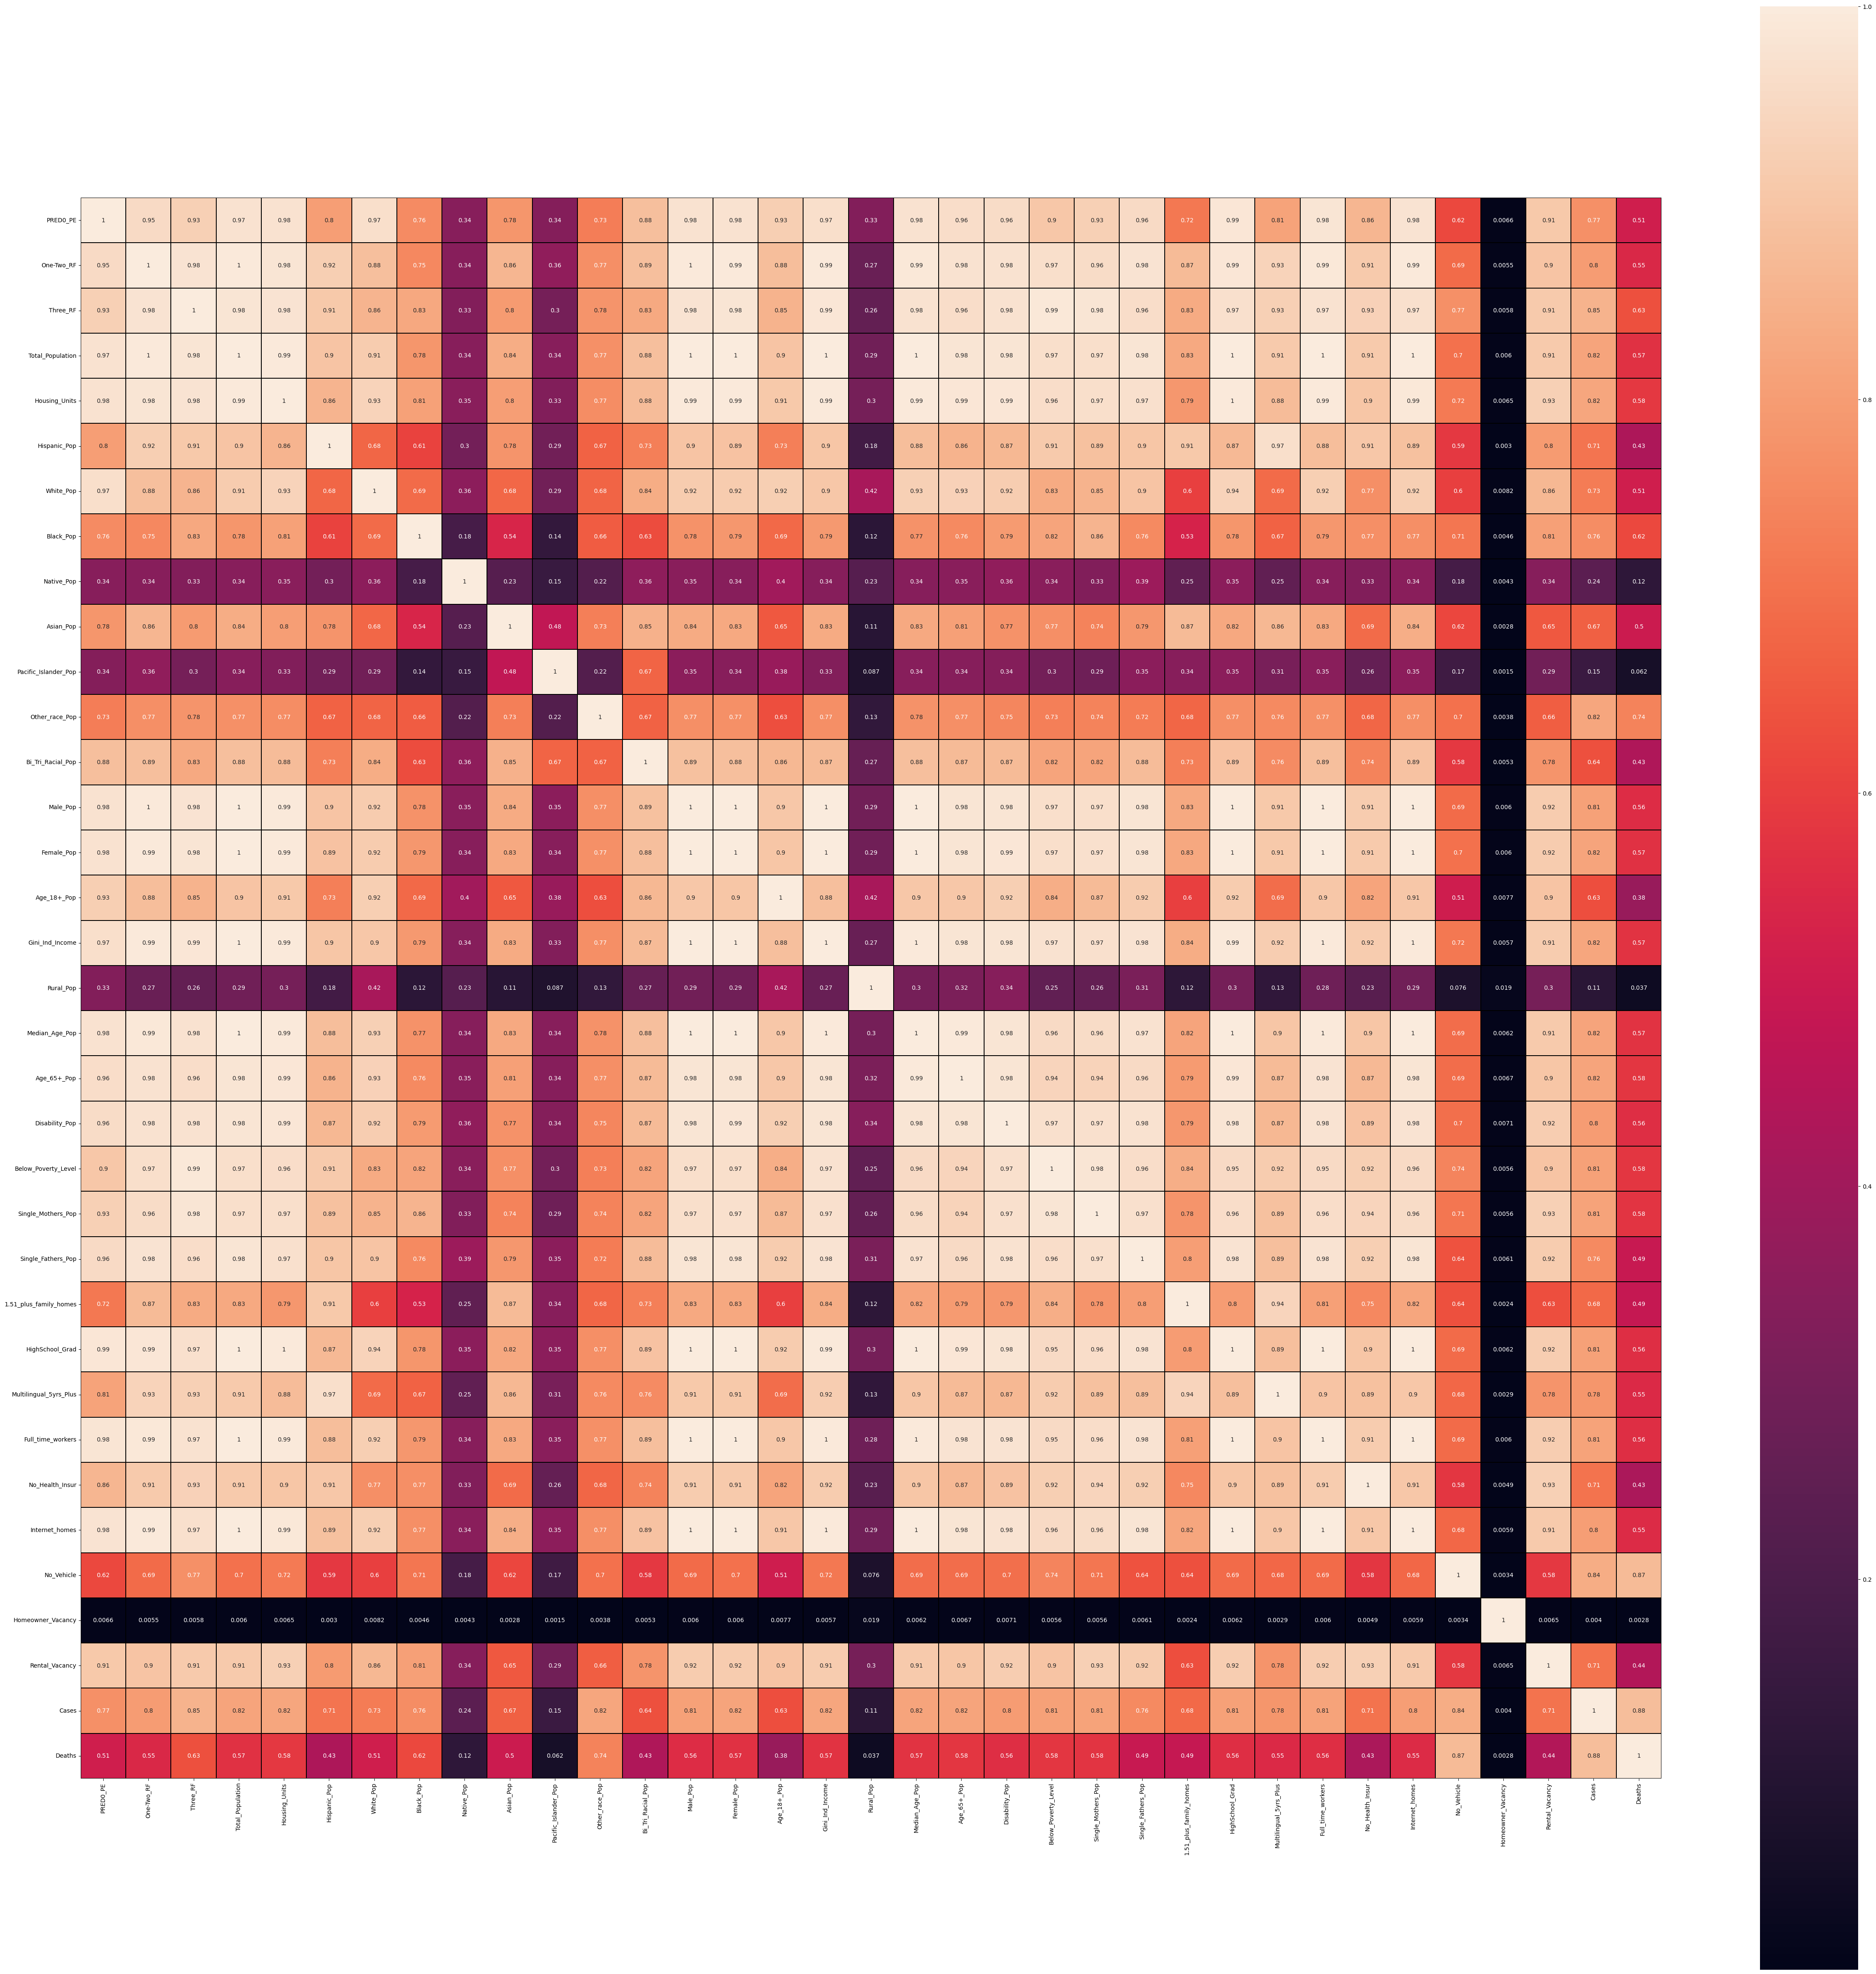

In [45]:
#heatmap with pearson coefficient values

corr = maybe_corr
plt.figure(figsize=(60,60))
sn.color_palette('rocket', as_cmap=True)
sn.heatmap(corr,vmax=1,linewidths=0.01,square=True,annot= True,linecolor='black')

In [46]:
save = plt.savefig('heatmap_edit2.png')
save

<Figure size 640x480 with 0 Axes>

In [ ]:



sns.pairplot(upper3, kind="reg")
plt.show()


In [ ]:
# Messing around 
# 
# 0_RF	Black_Pop	Native_Pop	Asian_Pop	Pacific_Islander_Pop	Other_race_Pop	Bi_Tri_Racial_Pop	Rural_Pop	No_Vehicle	Homeowner_Vacancy	Cases	Deaths
# One-Two_RF	Three_RF
merged_df_sel = merged_df3[['Zero_RF', 'One-Two_RF','Three_RF','Black_Pop', 'Native_Pop', 'Asian_Pop', 'Pacific_Islander_Pop',
                            'Other_race_Pop', 'Bi_Tri_Racial_Pop', 'Rural_Pop', 'No_Vehicle', 
                            'Homeowner_Vacancy', 'Cases','Deaths']]

sn.pairplot(merged_df_sel, hue='Zero_RF')

In [ ]:
## THANK YOU RAKSHA
merged_df_tx =np.log(merged_df_sel)



sn.pairplot(merged_df_tx, hue='Zero_RF')

In [ ]:
sn.pairplot(merged_df_tx, hue='One-Two_RF')

In [ ]:

# with regression
sns.pairplot(merged_df3, kind="reg")
plt.show()
 
# without regression
sns.pairplot(merged_df3, kind="scatter")
plt.show()

In [ ]:
# left
sns.pairplot(merged_df3, kind="scatter", hue="species", markers=["o", "s", "D"], palette="Set2")
plt.show()
 
# right: you can give other arguments with plot_kws.
sns.pairplot(merged_df3, kind="scatter", hue="species", plot_kws=dict(s=80, edgecolor="white", linewidth=2.5))
plt.show()